# Introduction

In the previous [article](https://dasaditi.github.io/Neural-Network-Back-Propagation/) I went over the math behind Neural Network. We have seen how to do forward propagation, then computed the loss function and went through the math behind the backward propagation in details. In this article we will implement a neural network from scratch in python.

We will be training 3-layer neural network with two hidden layer and one output layer (remember, we don't consider input in the layer count). The hidden layers will have RELU activation function whereas the output layer will have sigmoid activation function.
The code for this article is available [here](https://github.com/dasaditi/neuralNetwork/tree/master/ANN) as a Jupyter notebook, feel free to download and try it out yourself.

Before we go any further, let's look at the structure of the neural network we are going to build.

<img src="images/nnp-2.png"  />

For a L layer neural network, which has L-1 hidden layers and 1 output layer, the parameters (weights and biases) of the layer l are represented as:

- $W^{[l]}$: Weight matrix of dimension (size of layer $l-1$, size of layer $l$)

- $b^{[l]}$: Bias vector of dimension (1, size of layer $l$)

In addition to weights and biases, during the training process, following intermediate variables are computed:

- $Z^{[l]}$: Linear Activation of layer l.

- $g^{[l]}(.)$ : Non-linear function

- $A^{[l]}$: Non-linear activation. Output of $g^{[l]}(Z^{[l]})$ , where $A^{[0]}$ is the input data X.


# Gradient Descent Algorithm Recap
Training a neural network consists of 4 steps:

1. **Initialize** weights and biases.

2. **Forward propagation**: Using the input X, weights W and biases b, for every layer we compute Z and A. At the final layer, the activation function gives the prediction $\widehat{y}$.

3. **Compute the loss function**: This is a function of the actual label y and predicted label $\widehat{y}$. It captures how far off our predictions are from the actual target. Our objective is to minimize this loss function.

4. **Backward Propagation**: In this step, we calculate the gradients of the loss function f(y, $\widehat{y}$) with respect to A, W, and b called dA, dW and db. Using these gradients, we update the values of the parameters from the last layer to the first.

5. Repeat steps 2–4 for n iterations/epochs till we feel we have minimized the loss function, without overfitting the train data.

# Import Dependencies

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras import optimizers
import tensorflow.keras.utils as utils

# Load Dataset
For the purpose of this post, let's assume we have a dataset of 1000 records and two features. We will use a sample circle dataset using scikit learn.

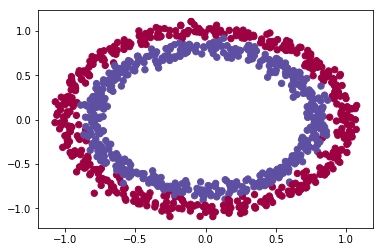

In [2]:
def load_dataset():
    np.random.seed(4)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=1000, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_Y = train_Y.reshape((train_Y.shape[0],1))
    test_Y = test_Y.reshape((test_Y.shape[0],1))
    return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = load_dataset()


# Initialize Weights and Biases

The weights $W^{[l]}$ should be initialized randomly to break symmetry. It is however okay to initialize the biases $b^{[l]}$  to zeros. Symmetry is still broken so long as  $W^{[l]}$  is initialized randomly.

We will initialize the weights from a random normal distribution. Biases are initialized to zero. The dimension of the weight matrix should be number of nodes (or neurons) in the previous layer by number of nodes in the current layer. Since the 0th layer is the input layer, we will consider the number of features instead of nodes.


In [3]:
def init_weights(layers_dims):
    """
    Initialize the weights from a random normal distribution
    Biases are initialized to zero
        
    W1 -- weight matrix of shape (layers_dims[0], layers_dims[1])
    b1 -- bias vector of shape (1,Initialize the weights from a random normal distribution)
                    ...
    WL -- weight matrix of shape (layers_dims[L-1], layers_dims[L])
    bL -- bias vector of shape (1 , layers_dims[L])
    """
    params={}
    np.random.seed(4) # Seed the random number generator
    L = len(layers_dims)   # integer representing the number of layers
    for l in range(1, L):
        params['W' + str(l)] = np.random.randn(layers_dims[l-1], layers_dims[l])
        params['b' + str(l)] = np.zeros((1,layers_dims[l]))
        
    return params


# Forward Propagation
Considering $X$ as **Layer-0**, $X$ can be represented as $A^{[0]}$. We can generalize the forward propagation equations for **Layer-l** as:

$$\large \bbox[10px, border: 2px solid black]{ Z^{[l]} = A^{[l-1]} \cdot W^{[1]} + b^{[1]} }$$

$$\large \bbox[10px, border: 2px solid black]{ A^{[l]} = g^{[l]}(Z^{[l]}) }$$

For the first two layers we will use RELU as activation function and for the output layer we will be using SIGMOID activation function.

> **Sigmoid** is an activation function of form f(x) = 1 / 1 + exp(-x). Its Range is between 0 and 1. **Relu** stands for Rectified Linear Units. The formula is deceptively simple: f(x) = max(0,x) 

<img src="images/nnp-3.png"  />

In [4]:
def relu(z):
    return np.maximum(0, z)
        
        
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def forward_propagation(X,params):
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    W3 = params["W3"]
    b3 = params["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(X , W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1 , W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2 , W3) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

> Note: We are returning all values computed in forward propagation in cache because we will be using them to calculate the derivatives during backward propagation.

# Compute Loss

All right, we had the actual values of y for each training example and now we have calculated the predicted values of y (the output of the third layer, a3 in our case). It's time to calculate the loss, the loss function used in classification of neural network is cross entropy loss. For a sample size of m records, the cost function is defined as:


$$\bbox[10px, border: 2px solid black]{\large J(W,b) = \frac{1}{m} \displaystyle\sum_{i=1}^{m} -y_i \cdot \log(\widehat{y_i}) - (1-y_i) \cdot log(1-\widehat{y_i})}$$  


In [5]:
def compute_loss(y, yhat):
    m = y.shape[0]
    logprobs = np.multiply(-np.log(yhat),y) + np.multiply(-np.log(1 - yhat), (1 - y))
    loss = 1./m * np.nansum(logprobs)
    return loss

# Backward Propagation

Unlike forward propagation, the gradients are calculated from right to left. That means we will start from the output layer and gradually proceed inward. I will not dig deep in the back propagration logic, rather I will bring back the equations we computed in my previous [article](https://dasaditi.github.io/Neural-Network-Back-Propagation/) and write code corresponding to them. I strongly suggest you go over backpropagation math [here](https://dasaditi.github.io/Neural-Network-Back-Propagation/) if you don't understand how it works completely.

<img src="images/nnp-4.png"  />

## Gradients of Layer-3

This is the outer layer where we calculate the gradient of the sigmoid activation function. The below equations were derived in my previous article, we will just apply them to the code.

<img src="images/nnp-5.png"  />

## The generic logic to calculate gradient for layer L

If you look closely at the gradients of each layer, you will find a pattern and that makes it so very easy to define the equations and code it.

$$ 
\frac{\partial loss}{\partial a^{[L]}}= da^{[L]} = dz^{[L+1]} \cdot {W^{[L+1]}}^T 
$$

$$  
\begin{equation} 
\frac{\partial loss}{\partial z^{[L]}}= dz^{[L]} = da^{[L]}* {g^{[L]}}^{\prime}(z^{[L]})
\end{equation} 
 $$

$$
\frac{\partial loss}{\partial W^{[L]}}= dW^{[L]} = {a^{[L-1]}}^T  \cdot dz^{[L]}
$$

$$  
\frac{\partial loss}{\partial b^{[L]}} = \displaystyle\sum_{i=1}^{m} dz^{[L]}
$$

## Gradients of Layer-2
The above generic equations can be applied to layer-2 and layer - 1 and derive the gradients easily.

<img src="images/nnp-6.png"  />

## Gradients of Layer-1

<img src="images/nnp-7.png"  />

In [6]:
def back_propagation(X,y,cache):
        
    m = X.shape[0]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    dz3 = 1./m * (a3 - y)
    dW3 = np.dot(a2.T ,dz3)
    db3 = np.sum(dz3, axis=0, keepdims = True)
    da2 = np.dot(dz3 , W3.T)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(a1.T , dz2)
    db2 = np.sum(dz2, axis=0, keepdims = True)
    da1 = np.dot(dz2, W2.T)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(X.T , dz1 )
    db1 = np.sum(dz1, axis=0, keepdims = True)
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

# Update Parameters

Once we have calculated the gradients, the last step is to update the weights with the derivative of the loss function.

In [7]:
def update_parameters(grads,params,learning_rate):
    L = len(params) //2
    # Update rule for each parameter
    for k in range(L):
        params["W" + str(k+1)] = params["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        params["b" + str(k+1)] = params["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
    return params

def accuracy(y, yhat):
    acc = sum(y == np.round(yhat)) / len(y) 
    return acc

# Putting it all Together

We have successfully built all components for the neural network. It's time to run the network and monitor the performance. We will run the network for 25000 iterations with a learning rate of 0.01. You will obeserve that the cost slowly goes down and accuracy improves with each iteration.

In [8]:
def model (X, y, layers=[], learning_rate=0.01, iterations=100):
    grads = {}
    costs = []
    acc=0
    #initialize weights and bias
    parameters = init_weights(layers) 
    for i in range(0, iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        a3, cache = forward_propagation(X,parameters)
        # Compute Loss
        cost = compute_loss(y,a3)
        acc = accuracy(y, a3)
        # Backward propagation.
        grads = back_propagation(X,y, cache)
        
        # Update parameters.
        parameters = update_parameters( grads,parameters,learning_rate)
        # Print the loss every 1000 iterations
        if i % 1000 == 0:
            print("Cost after iteration {}: {} and accuracy: {}".format(i, cost,acc))
            costs.append(cost)
    return costs, parameters 
                 


Cost after iteration 0: 1.7162788190920542 and accuracy: [0.5]
Cost after iteration 1000: 0.6935455829889666 and accuracy: [0.499]
Cost after iteration 2000: 0.6905406067392547 and accuracy: [0.514]
Cost after iteration 3000: 0.6891434906598779 and accuracy: [0.507]
Cost after iteration 4000: 0.6872602776622828 and accuracy: [0.508]
Cost after iteration 5000: 0.6843228956957375 and accuracy: [0.529]
Cost after iteration 6000: 0.6785453392737052 and accuracy: [0.54]
Cost after iteration 7000: 0.6681373938207664 and accuracy: [0.564]
Cost after iteration 8000: 0.6520194184819957 and accuracy: [0.637]
Cost after iteration 9000: 0.6269290706018096 and accuracy: [0.697]
Cost after iteration 10000: 0.5837699313056273 and accuracy: [0.789]
Cost after iteration 11000: 0.5227492398023532 and accuracy: [0.869]
Cost after iteration 12000: 0.4453596672561303 and accuracy: [0.899]
Cost after iteration 13000: 0.3471519362950478 and accuracy: [0.922]
Cost after iteration 14000: 0.2524945791460992 and

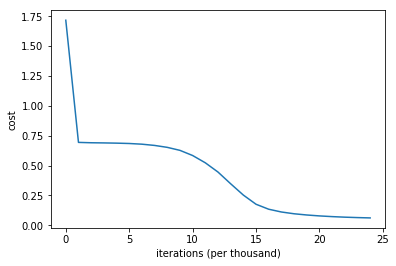

The values of the parameters  {'W1': array([[ 0.0064171 ,  2.61669562, -1.66190016,  0.34552322, -1.11333013,
        -1.25830041, -0.13408849,  0.89424884,  0.09592997, -2.26282354],
       [ 0.25209662, -0.65508892,  0.24824303,  0.1306075 , -2.78852762,
        -0.12950708, -0.50368833,  2.64772949,  0.39656779,  1.22252441]]), 'b1': array([[-0.2785923 , -0.81178253, -1.15994787, -0.39776044, -0.55797976,
        -0.47783316,  1.73482684, -1.26068583, -0.43198688, -0.83382491]]), 'W2': array([[-1.04120183e+00,  5.42512413e-02,  6.88349887e-02,
        -1.16117080e+00,  2.17144910e+00],
       [-3.24139538e-02,  2.45801540e+00, -1.14964342e+00,
         2.67441829e+00, -1.39485637e+00],
       [-1.00631627e+00,  1.50827362e+00, -1.84506166e-01,
        -2.25234761e+00, -1.45089243e+00],
       [ 7.52615551e-01,  2.07900624e+00,  8.71345704e-01,
        -2.62472411e-01,  7.70634904e-01],
       [-1.32361652e+00,  2.31239512e+00, -1.35535527e+00,
         1.49792720e+00, -1.86551611e-0

In [9]:
layers_dims = [train_X.shape[1], 10, 5, 1]
costs, parameters = model(train_X,train_Y,layers_dims, learning_rate=0.01, iterations = 25000)

# plot the loss
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per thousand)')
#plt.title("Learning rate =" + str(learning_rate))
plt.show()


# Final Thoughts
In this article we reviewd the logic of implementing a feed forward neural network and implemented on in python. I hope you have found this post useful. Happy learning :)

# The complete Neural Network

In [20]:
class NeuralNet():
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (number of examples,number of features)
    Y -- true "label" vector of shape (number of examples,1)
    layers -- A list containing number of neurons in each layer starting with input layer
    learning_rate -- learning rate for gradient descent 
    num_iterations -- number of iterations to run gradient descent
    print_cost -- if True, print the cost every 1000 iterations
    """
        
    def __init__(self, layers=[], learning_rate=0.001, iterations=100,print_cost = True):
        self.params = {}
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.print_cost=print_cost
        self.costs = []
        self.layers_dims = layers
        self.n_samples = None
        self.X = None
        self.y = None
                
    def init_weights(self):
        """
        Initialize the weights from a random normal distribution
        Biases are initialized to zero
        
        W1 -- weight matrix of shape (layers_dims[0], layers_dims[1])
        b1 -- bias vector of shape (1,Initialize the weights from a random normal distribution)
                    ...
        WL -- weight matrix of shape (layers_dims[L-1], layers_dims[L])
        bL -- bias vector of shape (1 , layers_dims[L])
        """
        np.random.seed(1) # Seed the random number generator
        L = len(self.layers_dims)            # integer representing the number of layers
        for l in range(1, L):
            self.params['W' + str(l)] = np.random.randn(self.layers_dims[l-1], self.layers_dims[l])
            self.params['b' + str(l)] = np.zeros((1,self.layers_dims[l]))
  

        
    def relu(self,z):
        '''
        The ReLufunction performs a threshold
        operation to each input element where values less 
        than zero are set to zero.
        '''
        return np.maximum(0, z)
        
        
    def sigmoid(self,z):
        '''
        The sigmoid function takes in real numbers in any range and 
        squashes it to a real-valued output between 0 and 1.
        '''
        return 1.0 / (1.0 + np.exp(-z))
    
    def compute_loss(self, yhat):

        """
        Implement the loss function
        Arguments:
        yhat -- post-activation, output of forward propagation
        Returns:
        loss - value of the loss function
        """
        m = self.n_samples
        logprobs = np.multiply(-np.log(yhat),self.y) + np.multiply(-np.log(1 - yhat), 1 - self.y)
        loss = 1./m * np.nansum(logprobs)
        return loss
    
    def forward_propagation(self,X):
        """
        Implements the forward propagation .
        Arguments:
        X -- input dataset, of shape ( number of examples,input size)

        Returns:
        a3 -- the predicted output
        """   
        
        W1 = self.params["W1"]
        b1 = self.params["b1"]
        W2 = self.params["W2"]
        b2 = self.params["b2"]
        W3 = self.params["W3"]
        b3 = self.params["b3"]
    
        # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
        z1 = np.dot(X , W1) + b1
        a1 = self.relu(z1)
        z2 = np.dot(a1 , W2) + b2
        a2 = self.relu(z2)
        z3 = np.dot(a2 , W3) + b3
        a3 = self.sigmoid(z3)
    
        cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
        return a3, cache

    
    def back_propagation(self,cache):
        
        """
        Implement the backward propagation.
        Arguments:
        X -- input dataset, of shape (input size, number of examples)
        Y -- true "label" vector (0 for red-dots and 1 for blue-dots)
        cache -- cache output from forward_propagation()
        Returns:
        gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
        """
        m = self.n_samples
        (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
        dz3 = 1./m * (a3 - self.y)
        dW3 = np.dot(a2.T ,dz3)
        db3 = np.sum(dz3, axis=0, keepdims = True)
        da2 = np.dot(dz3 , W3.T)
        dz2 = np.multiply(da2, np.int64(a2 > 0))
        dW2 = np.dot(a1.T , dz2)
        db2 = np.sum(dz2, axis=0, keepdims = True)
    
        da1 = np.dot(dz2, W2.T)
        dz1 = np.multiply(da1, np.int64(a1 > 0))
        dW1 = np.dot(self.X.T , dz1 )
        db1 = np.sum(dz1, axis=0, keepdims = True)
        gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
        return gradients

    #Update the coefficients
    def update_parameters(self, grads):
        """
        Update parameters using gradient descent
        Arguments:
        grads -- python dictionary containing your gradients, output of n_model_backward
        Returns:
        parameters -- python dictionary containing your updated parameters 
                  parameters['W' + str(i)] = ... 
                  parameters['b' + str(i)] = ...
        """
        L = len(self.params) // 2 # number of layers in the neural networks
        # Update rule for each parameter
        for k in range(L):
            self.params["W" + str(k+1)] = self.params["W" + str(k+1)] - self.learning_rate * grads["dW" + str(k+1)]
            self.params["b" + str(k+1)] = self.params["b" + str(k+1)] - self.learning_rate * grads["db" + str(k+1)]
 
        
    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        grads = {}
        self.n_samples= X.shape[0]
        self.X = X
        self.y = y
        self.init_weights() #initialize weights and bias

        for i in range(0, self.iterations):

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            a3, cache = self.forward_propagation(self.X)
        
            # Loss
            cost = self.compute_loss(a3)

            # Backward propagation.
            grads = self.back_propagation( cache)
        
            # Update parameters.
            self.update_parameters( grads)
            # Print the loss every 1000 iterations
            if self.print_cost and i % 1000 == 0:
                print("Cost after iteration {}: {}".format(i, cost))
                self.costs.append(cost)
                 
            
            
    def predict(self, X,y):
        """
        This function is used to predict the results of a  n-layer neural network.
        Arguments:
        X -- data set of examples you would like to label
        parameters -- parameters of the trained model
        Returns:
        p -- predictions for the given dataset X
        """
    
        # Forward propagation
        pred,cache  = self.forward_propagation(X)
        acc= self.acc(y, np.round(pred))
        
        # print results
        print("Accuracy: "  ,acc)
    
        return np.round(pred)

                                
    def acc(self, y, yhat):
        '''
        Calculates the accutacy between the predicted valuea and the truth labels
        '''
        acc = int(sum(y == yhat) / len(y) * 100)
        
        return acc


    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.costs)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()
        
    def getCosts(self):
        return self.costs
    
    def getParameters(self):
        return self.params

Cost after iteration 0: 1.300881993178413
Cost after iteration 1000: 0.6675980361731619
Cost after iteration 2000: 0.625552939397254
Cost after iteration 3000: 0.5428376408034848
Cost after iteration 4000: 0.4156644193704675
Cost after iteration 5000: 0.266779658250596
Cost after iteration 6000: 0.18124132501599888
Cost after iteration 7000: 0.13133001264114408
Cost after iteration 8000: 0.10395946269668191
Cost after iteration 9000: 0.0879026778151354
Cost after iteration 10000: 0.07747446173936312
Cost after iteration 11000: 0.06967731155674121
Cost after iteration 12000: 0.06357127583712963
Cost after iteration 13000: 0.05889146732250029
Cost after iteration 14000: 0.055375073367692595
Cost after iteration 15000: 0.05250308815748937
Cost after iteration 16000: 0.050161190378610394
Cost after iteration 17000: 0.0481721234217314
Cost after iteration 18000: 0.046470841445862436
Cost after iteration 19000: 0.04504230488278156
Cost after iteration 20000: 0.04385560458004885
Cost after it

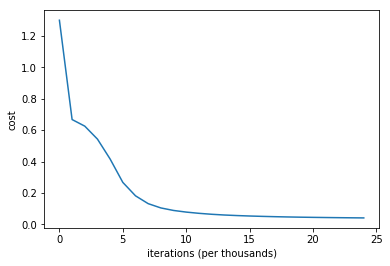

In [21]:
model = NeuralNet(layers_dims, learning_rate = 0.01, iterations = 25000, print_cost = True)
model.fit(train_X, train_Y)
parameters= model.getParameters()
costs=model.getCosts()

# plot the loss
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per thousands)')
#plt.title("Learning rate =" + str(learning_rate))
plt.show()